In [ ]:
## import pandas as pd
import numpy as np
import tensorflow as tf
import os 
from glob import glob
import tqdm
from tqdm import tqdm
import pandas as pd
import pydicom
import nrrd
from einops import rearrange, reduce, repeat

In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.model_selection import train_test_split

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# 내가 사용할 GPU번호(0,1,2,3)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True)
             
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized 
        print(e)

In [ ]:
def res_identity3(x, filters): 
    #full pre-activation

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv3D(f1, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(x)
        
    #second block # bottleneck (but size kept same with padding)

    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv3D(f2, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(x)

    # third block activation used after adding the input

    # add the input 
    x = Add()([x, x_skip])

    return x

def res_conv3(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)   
    x = Conv3D(f1, kernel_size=(3, 3, 3), strides=(s, s, s), padding='same')(x)
    # when s = 2 then it is like downsizing the feature map

    # second block
       
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)    
    x = Conv3D(f1, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    
    # shortcut 
#     x_skip = BatchNormalization()(x_skip)
    x_skip = Conv3D(f2, kernel_size=(1, 1, 1), strides=(s, s, s), padding='same')(x_skip)


    # add 
    x = Add()([x, x_skip])

    return x

In [ ]:
def resnet(input_shape=(128,128,128,1)):
    input_im = Input(shape=input_shape) 

    # 1st stage

    x = Conv3D(16, kernel_size=(3, 3, 3), padding='same')(input_im)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)    

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv3(x, s=2, filters=(16, 16))
    x = res_identity3(x, filters=(16, 16))

    # 3rd stage

    x = res_conv3(x, s=2, filters=(32, 32))
    x = res_identity3(x, filters=(32, 32))

    # 4th stage

    x = res_conv3(x, s=2, filters=(64, 64))
    x = res_identity3(x, filters=(64, 64))
    x = res_identity3(x, filters=(64, 64))

    # 5th stage

    x = res_conv3(x, s=2, filters=(128, 128))
    x = res_identity3(x, filters=(128, 128))
    x = res_identity3(x, filters=(128, 128))

    # 6th stage

    x = Conv3D(16, kernel_size=(3, 3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)  

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_im, outputs=x)

    return model
model = resnet()

In [ ]:
model.summary() #(58=(2,2,2,256),36=(4,4,4,128),21=(8,8,8,64),6=(16,16,16,32))

In [11]:
ptid = sorted(os.listdir('./data/original1125/'))
df_ptid = pd.DataFrame(ptid, columns=['ptid'])
all_inputpath = list('./data/original1125/'+df_ptid['ptid']+'/img/')
all_label = './data/original1125/'+df_ptid['ptid']
all_labelpath = []
for i in range(len(all_label)):
    all_labelpath.append(glob(all_label[i]+'/*.nrrd')[0])

In [ ]:
train_input_files = all_inputpath[:31]
train_label_files = all_labelpath[:31]

val_input_files = all_inputpath[31:38]
val_label_files = all_labelpath[31:38]

test_input_files = all_inputpath[38:]
test_label_files = all_labelpath[38:]

print(len(train_input_files), len(val_input_files), len(test_input_files))

In [ ]:
BATCH_SIZE = 8
img_size = 128
weights = None
# weights = 'imagenet'
learning_rate = 1e-4
EPOCHS = 400
dropout_rate = 0.1

In [ ]:
train_inp_files = glob(f'./data{img_size}/train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'./data{img_size}/train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'./data{img_size}/val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'./data{img_size}/val_label_img_{img_size}/*.npy')

In [ ]:
train_inp_files = glob(f'./data{img_size}/train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'./data{img_size}/train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'./data{img_size}/val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'./data{img_size}/val_label_img_{img_size}/*.npy')

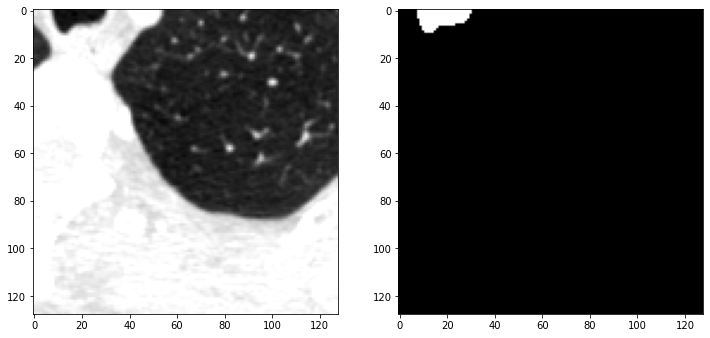

In [31]:
plt.figure(figsize=(12,6))
a = np.random.randint(0, len(train_inp_files))
plt.subplot(121)
plt.imshow(np.squeeze(np.load(train_inp_files[a]))[:,:,0], 'gray')
plt.subplot(122)
plt.imshow(np.squeeze(np.load(train_targ_files[a]))[:,:,0], 'gray')
plt.show()

In [ ]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files)

In [ ]:
def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)
    inp, targ = augmentation(inp, targ)
    
    return inp, targ

def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)
    return inp, targ

def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    
    return inp, targ

def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    
    return inp, targ

def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
        
    return inp, targ

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(val_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
from tensorflow.keras.utils import Sequence
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
				# sampler의 역할(index를 batch_size만큼 sampling해줌)
        # indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        # batch_x = [self.x[i] for i in indices]
        # batch_y = [self.y[i] for i in indices]

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), np.array(batch_y)


train_loader = Dataloader(X_train, y_train, 128)
valid_loader = Dataloader(X_valid, y_valid, 128)
# test_loader = Dataloader(x, y, 128)

history = model.fit(train_loader, epochs=300, 
                    validation_data=valid_loader,
                    callbacks=[cb]
                    )

In [ ]:
print(next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape)

In [ ]:
def convolution_block(x, filters, size, strides=(1,1,1), padding='same', activation=True):
    x = tf.keras.layers.Conv3D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3,3) )
    x = convolution_block(x, num_filters, (3,3,3), activation=False)
    x = tf.keras.layers.Add()([x, blockInput])
    return x

In [ ]:
def resunet3d(input_shape=(None, None, None, 1), dropout_rate=0.1, start_neurons = 8):
    backbone = resnet(input_shape=input_shape)
    input_layer = backbone.input
    
    conv4 = backbone.layers[58].output
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    pool4 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)
    
    convm = tf.keras.layers.Conv3D(start_neurons * 32, (3, 3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = tf.keras.layers.Conv3DTranspose(start_neurons * 16, (3, 3, 3), strides=(2, 2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)
    
    uconv4 = tf.keras.layers.Conv3D(start_neurons * 16, (3, 3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = tf.keras.layers.Conv3DTranspose(start_neurons * 8, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[36].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])    
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = tf.keras.layers.Conv3D(start_neurons * 8, (3, 3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = tf.keras.layers.Conv3DTranspose(start_neurons * 4, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
        
    uconv2 = tf.keras.layers.Dropout(0.1)(uconv2)
    uconv2 = tf.keras.layers.Conv3D(start_neurons * 4, (3, 3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = tf.keras.layers.Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[6].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    
    uconv1 = tf.keras.layers.Dropout(0.1)(uconv1)
    uconv1 = tf.keras.layers.Conv3D(start_neurons * 2, (3, 3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = tf.keras.layers.Conv3DTranspose(start_neurons * 1, (3, 3, 3), strides=(2, 2, 2), padding="same")(uconv1)   
    uconv0 = tf.keras.layers.Dropout(0.1)(uconv0)
    uconv0 = tf.keras.layers.Conv3D(start_neurons * 1, (3, 3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = tf.keras.layers.Conv3D(1, (1,1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = tf.keras.models.Model(input_layer, output_layer)
    
    return model

In [ ]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate)
model = resunet3d(input_shape=(img_size, img_size, img_size, 1),dropout_rate=dropout_rate)

model.compile(loss=dice_coef_loss, optimizer=optimizer)

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d_26 (Conv3D)             (None, 128, 128, 12  448         ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization_22 (BatchN  (None, 128, 128, 12  64         ['conv3d_26[0][0]']              
 ormalization)                  8, 16)                                                      

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='unet.png', show_shapes=True, show_layer_names=True)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'models/3dunet_dice_128.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )
]

In [ ]:
hist = model.fit(train_dataset, epochs=400, validation_data=val_dataset, callbacks=callbacks_list)

In [ ]:
plt.plot(hist.history["loss"], label='train_loss')
plt.plot(hist.history["val_loss"], label='val_loss')
plt.title('loss_plot')
plt.legend()
plt.show()